# Извлечение информации

* Именованные сущности: LOC, ORG, PER, TIME, GPE, 
* Отношения: _parent_(PER, PER), _worksIn_(PER, ORG), _locatedIn_(ORG, LOC)
* Факты: _bornIn_(PER, LOC, TIME), _newEmployee_(PER, ORG, occupation, TIME)
* События: _bornIn_("born", PER, LOC, TIME), _newEmployee_(new, PER, ORG, occupation, TIME)

# Сегодня: извлечение именованных сущностей [named entity recognition, NER]
* общие идеи
* локальный классификатор: RandomForest
* классификаторы последовательностей: CRF, biLSTM-CRF, charLSTM-wordLSTM

## Разметка


|             | В    | Британии | недавно | скончался | ученый | Стивен | Хокинг | .     |
|-------------|------|----------|---------|-----------|--------|--------|--------|-------|
| POS         | PREP | PROPN    | ADV     | VERB      | NOUN   | PROPN  | PROPN  | PUNCT |
| IOB (NE)    | O    | B-LOC    | B-TIME  | O         | O      | B-PER  | I-PER  | O     |
| IOBES (NE)  | O    | S-LOC    | S-TIME  | O         | O      | B-PER  | E-PER  | O     |
| IOB (REL)   |  O   | B-LOC    |  O      | O        |   O    |   B-PER     | I-PER        |    O  |
| IOB (EVENT)   |  O   | B-LOC    |  O      | B-Trigger/Death  | O| B-PER        |    I-PER  |O  |

## Задача классификации последовательности [sequence labelling]

* $ \mathbf{x} = x_1, x_2, \ldots, x_n$, $x_i \in V$, $V$ - словарь
* $ \mathbf{y} = y_1, y_2, \ldots, y_n$, $x_y \in L$, $L$ - метки
* ${(\mathbf{x}^{(1)}, \mathbf{y}^{(1)}), (\mathbf{x}^{(2)}, \mathbf{y}^{(2)}), \ldots, (\mathbf{x}^{(m)}, \mathbf{y}^{(m)})}$ - обучающие данные


Задача: обучить классификатор $\mathbf{x} \rightarrow \mathbf{y}$


### Локальные методы
Задача: определить класс данного токена $x_i$ или данной группы или $n$-грамы $x_{i:j}$ (или данной пары токенов ( $(x_i, x_j) \in R?$ )
* Правила и словари
* Любой алгоритм классификации (Random Forest, Naive Bayes, ConvNets)

### Глобальные методы
Задача: определить лучшую последовательность меток: $\arg \max_{Y} P(Y|X)$
* Правила и словари
* Марковские модели максимальной энтропии [Maximum entropy Markov model, MEMM]
* Условные случайные поля [Conditional random field, CRF]
* Рекуррентные нейронные сети
* Структурированный метод опорных векторов [SVM$^{struct}$]

### Признаки для слов
* Регистр слова, есть ли строчные, заглавные буквы, аббревиатуры
* Префикс и суффикс слова
* Входит ли слово в словарь (например, список городов, имен, фамилий и др.)
* Часть речи слова, разбор слова
* Лемма или псевдооснова (стем) слова
* Синтаксические зависимости слова
* Семантическая роль слова
* Все тоже самое для левого и правого контекста 

### Признаки для групп или $n$-грам
* Удовлетворяет ли группа или $n$-грама морфологическому шаблону
* Есть ли в группе или $n$-граме специфическое слово?
* Входит ли группа или $n$-грама в каком-нибудь словарь?

### Оценки качества извлечения именованных сущностей
* macro-, macro-, precision, recall, f1-measure, accuracy 
* оценка на уровне токенов / групп

### Проблемы
1. Многозначность: Пушкин (PER/LOC), Paris Hilton (PER PER / LOC ORG);
2. Вложенность: [ректор [НИУ ВШЭ] [Я. И. Кузьминов]]
3. Кореференция: Москва/LOC - столица России/LOC. Она/? стоит на берегу [р. Москвы]/LOC. 

### Данные
* Английский: СoNLL 2003, OntosNotes 5.0, ACE, kaggle (GMB корпус)
* Русский: FactRuEval (очень странный корпус)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain


import pandas as pd
import numpy as np

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV



from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


import eli5

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn_crfsuite.metrics import flat_classification_report


from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, concatenate, SpatialDropout1D

# Эксперименты

## Данные: kaggle (GMB корпус)

In [3]:
data = pd.read_csv("C:/Users/adwiz/Documents/Courses/datascience_netology/datasets/nlp/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

In [4]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
words = list(set(data["Word"].values))

In [6]:
n_words = len(words); n_words

35178

In [7]:
data['Tag'].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try:
            s = self.data[self.data["Sentence #"] == "Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].values.tolist()    
        except:
            self.empty = True
            return None, None, None

In [9]:
getter = SentenceGetter(data)
sent, pos, tag = getter.get_next()
print(sent, pos, tag)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.'] ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP', 'TO', 'VB', 'DT', 'NN', 'IN', 'NNP', 'CC', 'VB', 'DT', 'NN', 'IN', 'JJ', 'NNS', 'IN', 'DT', 'NN', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


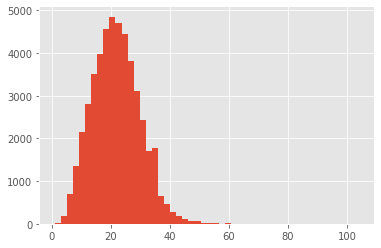

In [10]:
sentences = getter.sentences
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
class MemoryTagger(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y):
        '''
        Expects a list of words as X and a list of tags as y.
        '''
        voc = {}
        self.tags = []
        for x, t in zip(X, y):
            if t not in self.tags:
                self.tags.append(t)
            if x in voc:
                if t in voc[x]:
                    voc[x][t] += 1
                else:
                    voc[x][t] = 1
            else:
                voc[x] = {t: 1}
        self.memory = {}
        for k, d in voc.items():
            self.memory[k] = max(d, key=d.get)
    
    def predict(self, X, y=None):
        '''
        Predict the the tag from memory. If word is unknown, predict 'O'.
        '''
        return [self.memory.get(x, 'O') for x in X]

#### Классификатор на правилах: MemoryTagger

1. Запоминаем сколько раз и каким тегом было помечено слово
2. Предсказываем самый частый тег
3. Не работает для несловарных слов

In [12]:
tagger = MemoryTagger()
tagger.fit(sent, tag)

In [13]:
print(sent)
print(tagger.predict(sent))

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [14]:
words = data['Word'].values.tolist()
tags = data['Tag'].values.tolist()
pred = cross_val_predict(estimator=MemoryTagger(), X=words, y=tags, cv=5)

In [15]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.20      0.05      0.09       402
       B-eve       0.54      0.25      0.34       308
       B-geo       0.78      0.85      0.81     37644
       B-gpe       0.94      0.93      0.94     15870
       B-nat       0.42      0.28      0.33       201
       B-org       0.67      0.49      0.56     20143
       B-per       0.78      0.65      0.71     16990
       B-tim       0.87      0.77      0.82     20333
       I-art       0.04      0.01      0.01       297
       I-eve       0.39      0.12      0.18       253
       I-geo       0.73      0.58      0.65      7414
       I-gpe       0.62      0.45      0.52       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.69      0.53      0.60     16784
       I-per       0.73      0.65      0.69     17251
       I-tim       0.58      0.13      0.21      6528
           O       0.97      0.99      0.98    887908

    accuracy              

#### Случайный лес
Зададим признаковое пространство.

In [16]:
def feature_map(word):
    '''Simple feature map.'''
    return np.array([word.istitle(), word.islower(), word.isupper(), len(word),
                    word.isdigit(), word.isalpha()])

feature_map('Paris')

array([1, 0, 0, 5, 0, 1])

In [17]:
words = [feature_map(w) for w in data['Word'].values.tolist()]

In [18]:
pred = cross_val_predict(RandomForestClassifier(n_estimators=20),
                        X=words, y=tags, cv=5)

In [19]:
report = classification_report(y_pred=pred, y_true=tags, zero_division=True)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.00      0.00      0.00       308
       B-geo       0.26      0.80      0.40     37644
       B-gpe       0.25      0.03      0.05     15870
       B-nat       1.00      0.00      0.00       201
       B-org       0.65      0.17      0.27     20143
       B-per       0.97      0.20      0.33     16990
       B-tim       0.29      0.32      0.30     20333
       I-art       1.00      0.00      0.00       297
       I-eve       1.00      0.00      0.00       253
       I-geo       1.00      0.00      0.00      7414
       I-gpe       1.00      0.00      0.00       198
       I-nat       0.00      0.00      0.00        51
       I-org       0.36      0.03      0.06     16784
       I-per       0.47      0.02      0.04     17251
       I-tim       0.50      0.06      0.11      6528
           O       0.97      0.98      0.97    887908

    accuracy              

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


class FeatureTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.memory_tagger = MemoryTagger()
        self.tag_encoder = LabelEncoder()
        self.pos_encoder = LabelEncoder()
        
    def fit(self, X, y):
        words = X["Word"].values.tolist()
        self.pos = X["POS"].values.tolist()
        tags = X["Tag"].values.tolist()
        self.memory_tagger.fit(words, tags)
        self.tag_encoder.fit(tags)
        self.pos_encoder.fit(self.pos)
        return self
    
    def transform(self, X, y=None):
        def pos_default(p):
            if p in self.pos:
                return self.pos_encoder.transform([p])[0]
            else:
                return -1
        
        pos = X["POS"].values.tolist()
        words = X["Word"].values.tolist()
        out = []
        for i in range(len(words)):
            w = words[i]
            p = pos[i]
            if i < len(words) - 1:
                wp = self.tag_encoder.transform(self.memory_tagger.predict([words[i+1]]))[0]
                posp = pos_default(pos[i+1])
            else:
                wp = self.tag_encoder.transform(['O'])[0]
                posp = pos_default(".")
            if i > 0:
                if words[i-1] != ".":
                    wm = self.tag_encoder.transform(self.memory_tagger.predict([words[i-1]]))[0]
                    posm = pos_default(pos[i-1])
                else:
                    wm = self.tag_encoder.transform(['O'])[0]
                    posm = pos_default(".")
            else:
                posm = pos_default(".")
                wm = self.tag_encoder.transform(['O'])[0]
            out.append(np.array([w.istitle(), w.islower(), w.isupper(), len(w), w.isdigit(), w.isalpha(),
                                 self.tag_encoder.transform(self.memory_tagger.predict([w]))[0],
                                 pos_default(p), wp, wm, posp, posm]))
        return out

Признаковое пространство: FeatureTransformer
  * w.istitle(), w.islower(), len(w), w.isdigit(), w.isalpha()
  * самый частый тег этого слова: memory_tagger.predict([w])
  * самый частый тег и часть речи левого слова
  * самый частый тег и часть речи правого слова

In [21]:
sentl = data[:24]
ft = FeatureTransformer()
ft.fit(sentl, None)
ft.transform(sentl)

[array([1, 0, 0, 9, 0, 1, 2, 7, 2, 2, 3, 0], dtype=int64),
 array([0, 1, 0, 2, 0, 1, 2, 3, 2, 2, 7, 7], dtype=int64),
 array([ 0,  1,  0, 13,  0,  1,  2,  7,  2,  2, 11,  3], dtype=int64),
 array([ 0,  1,  0,  4,  0,  1,  2, 11,  2,  2, 10,  7], dtype=int64),
 array([ 0,  1,  0,  7,  0,  1,  2, 10,  2,  2,  3, 11], dtype=int64),
 array([ 0,  1,  0,  7,  0,  1,  2,  3,  0,  2,  6, 10], dtype=int64),
 array([1, 0, 0, 6, 0, 1, 0, 6, 2, 2, 8, 3], dtype=int64),
 array([0, 1, 0, 2, 0, 1, 2, 8, 2, 0, 9, 6], dtype=int64),
 array([0, 1, 0, 7, 0, 1, 2, 9, 2, 2, 2, 8], dtype=int64),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9], dtype=int64),
 array([0, 1, 0, 3, 0, 1, 2, 5, 2, 2, 3, 2], dtype=int64),
 array([0, 1, 0, 2, 0, 1, 2, 3, 0, 2, 6, 5], dtype=int64),
 array([1, 0, 0, 4, 0, 1, 0, 6, 2, 2, 1, 3], dtype=int64),
 array([0, 1, 0, 3, 0, 1, 2, 1, 2, 0, 9, 6], dtype=int64),
 array([0, 1, 0, 6, 0, 1, 2, 9, 2, 2, 2, 1], dtype=int64),
 array([0, 1, 0, 3, 0, 1, 2, 2, 2, 2, 5, 9], dtype=int64),
 array([

In [22]:
pred = cross_val_predict(Pipeline([('feature_map', FeatureTransformer()),
                                  ('clf', RandomForestClassifier(n_estimators=20, n_jobs=3))]),
                        X=data, y=tags, cv=5)

In [23]:
report = classification_report(y_pred=pred, y_true=tags)
print(report)

              precision    recall  f1-score   support

       B-art       0.14      0.07      0.10       402
       B-eve       0.40      0.27      0.32       308
       B-geo       0.83      0.86      0.84     37644
       B-gpe       0.98      0.93      0.95     15870
       B-nat       0.20      0.23      0.21       201
       B-org       0.74      0.64      0.68     20143
       B-per       0.82      0.75      0.78     16990
       B-tim       0.89      0.80      0.84     20333
       I-art       0.03      0.01      0.02       297
       I-eve       0.23      0.13      0.16       253
       I-geo       0.76      0.67      0.71      7414
       I-gpe       0.72      0.46      0.56       198
       I-nat       0.47      0.18      0.26        51
       I-org       0.73      0.68      0.70     16784
       I-per       0.85      0.74      0.79     17251
       I-tim       0.82      0.53      0.64      6528
           O       0.98      0.99      0.99    887908

    accuracy              

#### Условные случайные поля


Лучшая последовательность тегов:  $ \hat{Y} =  \arg \max_Y P(Y|X) $

<img src="img/ner_seq1.png" width="400">

Лог-линейная модель:
* $F(y,x)$ - оценка качества одного разбора
* $\lambda$ - веса
* Глобальная нормализация:

$p(y|x, \lambda) =  \frac{exp{\sum_{i=1}^k \lambda_i F_i(y,x) }}{\sum_{y' \in C^n} exp { \sum_{i=1}^k \lambda_i F_i(y',x) }} $


* $F(y,x) = \sum_i f(y_{i-1}, y_i, x, i)$ - (транзиторный) признак, $f \in {0,1}$

Пример:

$f = 1 : y_{i-1} = $O, $y_i = $LOC, $x = $Пушкин


$f = 0 : иначе

#### Классификатор на основе CRF: crf_suite
word2features задает признаковое пространство для текущего слова, его левого и правого
контекста

In [24]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(), 
        'word.istitle()': word.istitle(),
        'word.istitle()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [25]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]
X[0][0]

{'bias': 1.0,
 'word.lower()': 'thousands',
 'word[-3:]': 'nds',
 'word[-2:]': 'ds',
 'word.isupper()': False,
 'word.istitle()': False,
 'postag': 'NNS',
 'postag[:2]': 'NN',
 'BOS': True,
 '+1:word.lower()': 'of',
 '+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:postag': 'IN',
 '+1:postag[:2]': 'IN'}

In [26]:
from sklearn_crfsuite import CRF

crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

In [41]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

In [42]:
report = flat_classification_report(y_pred=pred, y_true=y, zero_division=True)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.78      0.27      0.40       308
       B-geo       0.82      0.90      0.86     37644
       B-gpe       0.94      0.90      0.92     15870
       B-nat       0.73      0.11      0.19       201
       B-org       0.78      0.67      0.72     20143
       B-per       0.80      0.76      0.78     16990
       B-tim       0.93      0.83      0.88     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.63      0.14      0.23       253
       I-geo       0.80      0.74      0.77      7414
       I-gpe       0.95      0.30      0.46       198
       I-nat       1.00      0.00      0.00        51
       I-org       0.75      0.76      0.75     16784
       I-per       0.80      0.90      0.85     17251
       I-tim       0.83      0.67      0.74      6528
           O       0.99      0.99      0.99    887908

    accuracy              

In [28]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [30]:
eli5.show_weights(crf, top=30)

C:\Users\adwiz\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,4.41,1.376,0.0,1.909,0.0,2.12,0.0,1.73,0.0,0.998,0.0,2.278,0.0,4.401,0.0,3.533,0.0
B-art,-0.118,0.0,8.384,0.0,0.0,-0.736,0.0,0.0,0.0,0.0,0.0,0.162,0.0,0.0,0.0,0.532,0.0
I-art,-0.667,0.0,7.979,0.0,0.0,-1.164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.656,0.0,-0.837,0.0
B-eve,-0.07,0.0,0.0,0.0,8.923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.944,0.0
I-eve,-0.247,0.0,0.0,0.0,8.441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.72,0.0
B-geo,1.104,1.179,0.0,1.114,0.0,0.0,8.661,0.986,0.0,0.0,0.0,1.063,0.0,1.347,0.0,3.103,0.0
I-geo,0.245,1.462,0.0,0.0,0.0,0.0,7.453,-0.862,0.0,0.0,0.0,-0.086,0.0,1.815,0.0,1.858,0.0
B-gpe,1.266,-0.787,0.0,0.0,0.0,0.69,0.0,0.0,8.801,0.0,0.0,2.036,0.0,1.961,0.0,1.556,0.0
I-gpe,-0.551,0.0,0.0,0.0,0.0,-1.174,0.0,0.0,7.844,0.0,0.0,0.0,0.0,0.404,0.0,0.0,0.0
B-nat,-0.301,0.0,0.0,0.0,0.0,1.049,0.0,0.0,0.0,0.0,7.158,0.0,0.0,0.629,0.0,0.402,0.0


In [34]:
crf = CRF(algorithm='lbfgs',
         c1=10,
         c2=.1,
         max_iterations=100,
         all_possible_transitions=False)

In [35]:
pred = cross_val_predict(estimator=crf, X=X, y=y, cv=5)

C:\Users\adwiz\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [39]:
report = flat_classification_report(y_pred=pred, y_true=y, zero_division=True)
print(report)

              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       402
       B-eve       0.78      0.27      0.40       308
       B-geo       0.82      0.90      0.86     37644
       B-gpe       0.94      0.90      0.92     15870
       B-nat       0.73      0.11      0.19       201
       B-org       0.78      0.67      0.72     20143
       B-per       0.80      0.76      0.78     16990
       B-tim       0.93      0.83      0.88     20333
       I-art       0.00      0.00      0.00       297
       I-eve       0.63      0.14      0.23       253
       I-geo       0.80      0.74      0.77      7414
       I-gpe       0.95      0.30      0.46       198
       I-nat       1.00      0.00      0.00        51
       I-org       0.75      0.76      0.75     16784
       I-per       0.80      0.90      0.85     17251
       I-tim       0.83      0.67      0.74      6528
           O       0.99      0.99      0.99    887908

    accuracy              

In [37]:
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=False, c1=10, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [38]:
eli5.show_weights(crf, top=30)

From \ To,O,B-art,I-art,B-eve,I-eve,B-geo,I-geo,B-gpe,I-gpe,B-nat,I-nat,B-org,I-org,B-per,I-per,B-tim,I-tim
O,3.611,1.69,0.0,1.407,0.0,2.06,0.0,1.949,0.0,1.662,0.0,2.179,0.0,3.313,0.0,2.34,0.0
B-art,0.0,0.0,8.062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-art,-0.488,0.0,7.537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-eve,-0.314,0.0,0.0,0.0,8.297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
I-eve,0.0,0.0,0.0,0.0,7.933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-geo,0.882,0.0,0.0,0.0,0.0,0.0,9.932,1.187,0.0,0.0,0.0,0.604,0.0,-0.032,0.0,1.807,0.0
I-geo,-0.398,0.0,0.0,0.0,0.0,0.0,8.109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.169,0.0
B-gpe,1.17,0.0,0.0,0.0,0.0,0.096,0.0,0.0,5.877,0.0,0.0,1.265,0.0,0.934,0.0,0.0,0.0
I-gpe,-0.485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B-nat,-0.724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.678,0.0,0.0,0.0,0.0,0.0,0.0
